<div class="alert alert-block alert-success" style="font-size:30px">
[infer] Pytorch:auxilliary targets+weighted loss+thresholds
</div>


<div class="alert alert-block alert-info">
    📌 Note, that this is the inference part. Refer to the training part for more details: <a href="https://www.kaggle.com/vslaykovsky/train-effnetv2-aux-targets-weighted-loss-thres">[train] Pytorch:aux targets+weighted loss+thres</a>
</div>

This is a PyTorch implementation of multi-model ensemble classifier.

Here is a high level explanation of the **inference** flow:
1. Images are loaded from test folder and transformed to `3x1024x512` tensors using the same transformations used in training.
2. Images are passed to an ensemble of trained `seresnext50`-based classifiers. The classifier produces probability of cancer.
3. Thresholds produced by the training pipeline are applied in inference to improve the target metric (pF1)
4. Ensemble is implemented with majority voting (`np.median`). This is because predictions are binary after step (3). votes are collected accross different views and different base models (e.g. 2 views * 5 models)

<div class="alert alert-block alert-danger" style="text-align:center; font-size:16px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>

<div class="alert alert-block alert-success" style="font-size:25px">
 1. Imports, constants and dependencies 
</div>

In [1]:

try:
    import pylibjpeg
except:
    !pip install -q /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install -q /kaggle/input/rsna-bcd-whl-ds/python_gdcm-3.0.20-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
    # !pip install -q /kaggle/input/rsna-bcd-whl-ds/pylibjpeg-1.4.0-py3-none-any.whl
    !pip install -q /kaggle/input/rsna-bcd-whl-ds/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl

In [2]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
from timm import create_model
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
import cv2
import dicomsdl

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
plt.rcParams['figure.figsize'] = (20, 5)



RSNA_2022_PATH = '/kaggle/input/rsna-breast-cancer-detection'
PNG_TEST_IMAGES_PATH = f'test'
MODELS_PATH = '/kaggle/input/wandb-models/models'
DCM_TEST_IMAGES_PATH = f'/kaggle/input/rsna-breast-cancer-detection/test_images'

AUX_TARGET_NCLASSES = [2, 2, 6, 2, 2, 2, 4, 5, 2, 10, 10]


try:
    from kaggle_secrets import UserSecretsClient
    IS_KAGGLE = True
except:
    IS_KAGGLE = False

DEBUG = True

if not IS_KAGGLE:
    print('Running locally')
    RSNA_2022_PATH = 'data'
    DCM_TEST_IMAGES_PATH = f'data/test_images'
    MODELS_PATH = 'models_roi_1024_v2'


DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 16
else:
    BATCH_SIZE = 2

     
    
class CFG:
    resize_dim = 1024
    aspect_ratio = True
    img_size = [1024, 512]

<div class="alert alert-block alert-success" style="font-size:25px">
    2. Loading test dataframe
</div>
 

In [3]:
def load_df_test():
    df_test = pd.read_csv(f'{RSNA_2022_PATH}/test.csv')
    return df_test

df_test = load_df_test()

df_test

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


<div class="alert alert-block alert-success" style="font-size:25px">
    3. Dataset class
</div>

`BreastCancerDataset` class returns individual images. It uses a dataframe parameter `df` as a source of metadata to locate and load images from `path` folder. 

### Preprocess images ROI

In [4]:
!rm -rf test

In [5]:
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
import re
import pydicom

def fit_image(fname, size=1024):
    # 1. Read, resize
    
    
    patient = fname.split('/')[-2]
    image = fname.split('/')[-1][:-4]
    dicom = pydicom.dcmread(fname)
    img = dicom.pixel_array
    img = (img - img.min()) / (img.max() - img.min())
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = 1 - img
    img = cv2.resize(img, (size, size))
    
    # 2. Crop
    X = img
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
    X = X[5:-5, 5:-5]
    
    
    # regions of non-empty pixels
    output= cv2.connectedComponentsWithStats((X > 0.05).astype(np.uint8)[:, :], 8, cv2.CV_32S)

    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]
    
    # finding max area which always corresponds to the breast data. 
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    # cutting out the breast data
    X_fit = X[y1: y2, x1: x2]
    
    patient_id, im_id = os.path.basename(os.path.dirname(fname)), os.path.basename(fname)[:-4]
    os.makedirs(f'{PNG_TEST_IMAGES_PATH}/test_images/{patient_id}', exist_ok=True)
    cv2.imwrite(f'{PNG_TEST_IMAGES_PATH}/test_images/{patient_id}/{im_id}.png', (X_fit[:, :] * 255).astype(np.uint8))

def fit_all_images(all_images):
    with ThreadPoolExecutor(2) as p:
        for i in tqdm(p.map(fit_image, all_images), total=len(all_images)):
            pass

all_images = glob.glob('/kaggle/input/rsna-breast-cancer-detection/test_images/*/*') 
# all_images = glob.glob('/kaggle/input/rsna-breast-cancer-detection/train_images/10006/*')
fit_all_images(all_images)

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
!find test | head

test
test/test_images
test/test_images/10008
test/test_images/10008/736471439.png
test/test_images/10008/1591370361.png
test/test_images/10008/361203119.png
test/test_images/10008/68070693.png


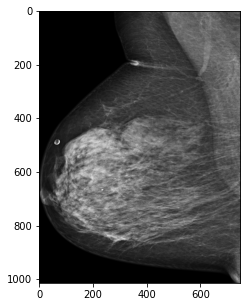

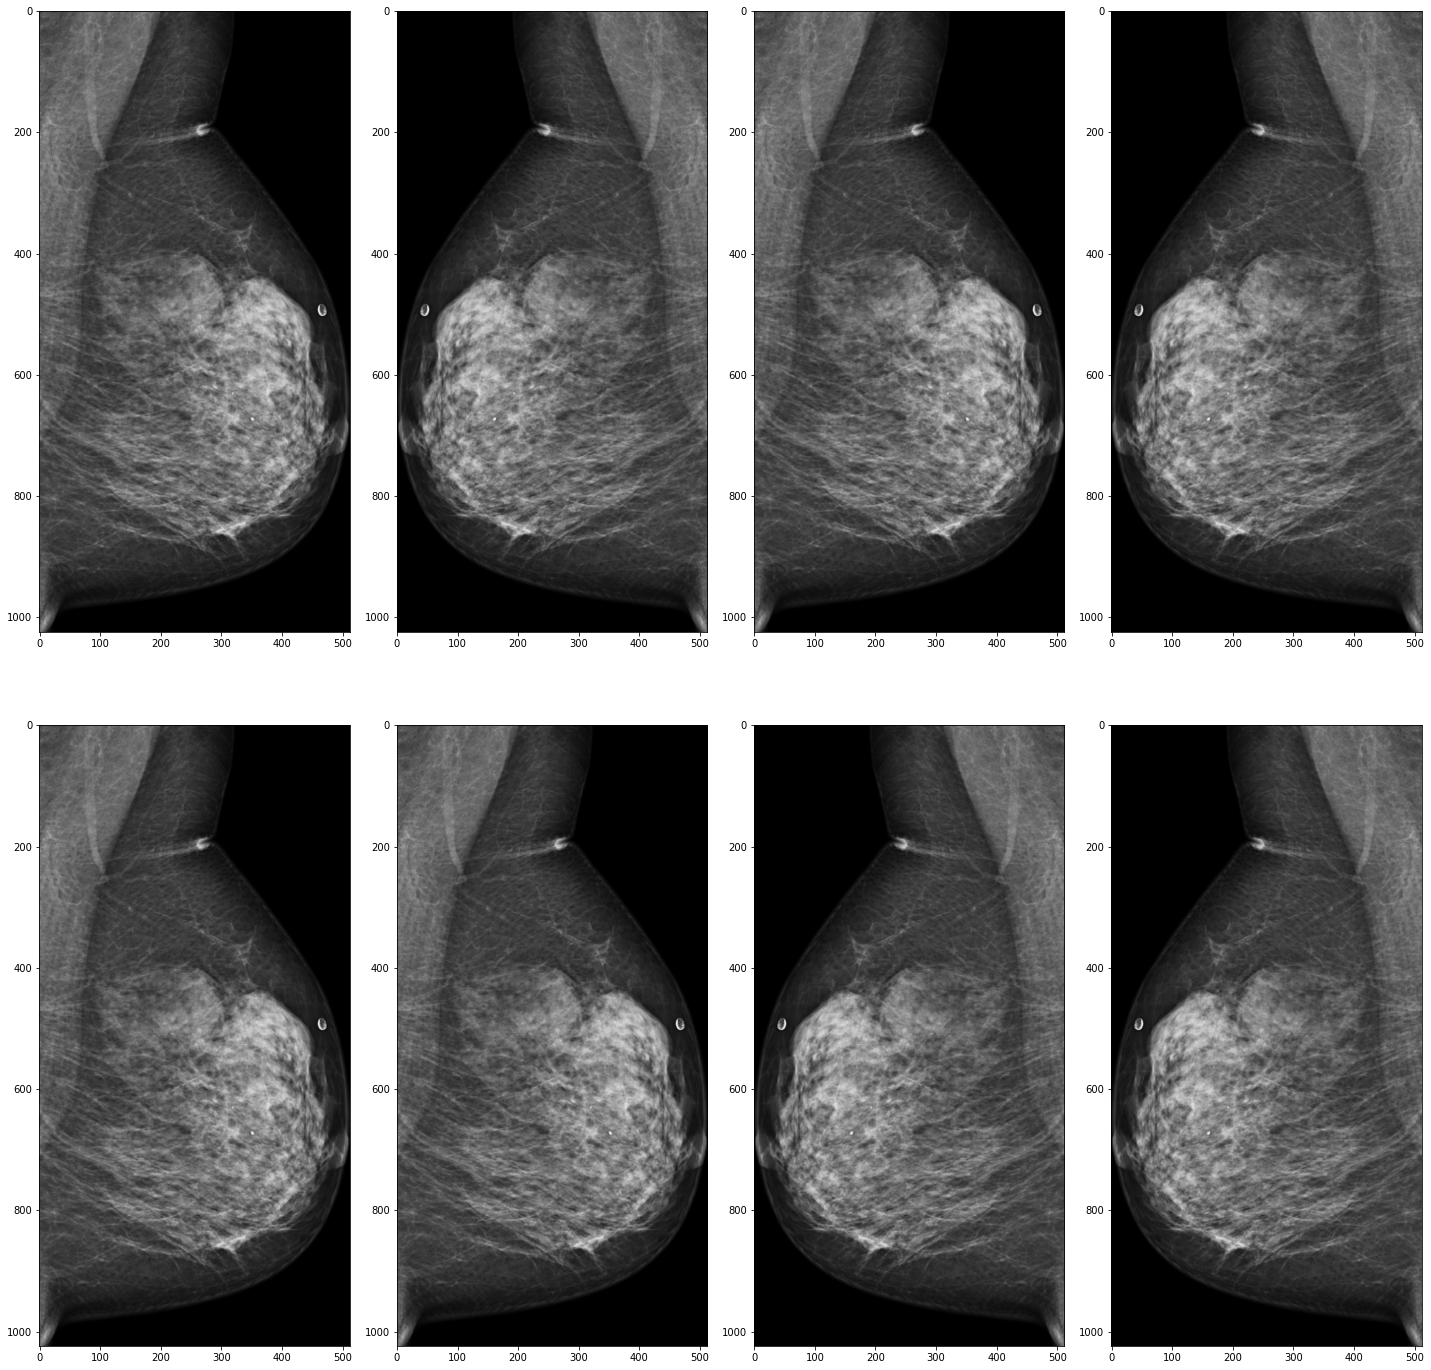

In [7]:
import torchvision
from PIL import Image

def get_transforms(aug=False):

    def transforms(img):
        img = img.convert('RGB')#.resize((512, 512))
        if aug:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.RandomRotation(degrees=(-5, 5)), 
                torchvision.transforms.RandomResizedCrop((1024, 512), scale=(0.8, 1), ratio=(0.45, 0.55)) 
            ]
        else:
            tfm = [
                torchvision.transforms.RandomHorizontalFlip(0.5),
                torchvision.transforms.Resize((1024, 512))
            ]
        img = torchvision.transforms.Compose(tfm + [            
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=0.2179, std=0.0529),
            
        ])(img)
        return img

    return lambda img: transforms(img)

if DEBUG:
    tfm = get_transforms(aug=False)
    img = Image.open(f"{PNG_TEST_IMAGES_PATH}/test_images/10008/68070693.png")
    plt.imshow(np.array(img), cmap='gray')
    plt.show()

    plt.figure(figsize=(20, 20))
    for i in range(8):
        v = tfm(img).permute(1, 2, 0)
        v -= v.min()
        v /= v.max()
        # plt.imshow(v)
        # break
        plt.subplot(2, 4, i + 1).imshow(v)
    plt.tight_layout()

In [8]:
from PIL import Image


class BreastCancerDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):

        path = f'{self.path}/test_images/{self.df.iloc[i].patient_id}/{self.df.iloc[i].image_id}.png'
        try:
            img = Image.open(path).convert('RGB')
        except Exception as ex:
            print(path, ex)
            return None

        if self.transforms is not None:
            img = self.transforms(img)


        return img

    def __len__(self):
        return len(self.df)

ds_test = BreastCancerDataSet(df_test, PNG_TEST_IMAGES_PATH, get_transforms(False))
if DEBUG:
    X, y_cancer, y_aux = ds_test[2]
    print(X.shape, y_cancer.shape, y_aux.shape)

torch.Size([1024, 512]) torch.Size([1024, 512]) torch.Size([1024, 512])


<div class="alert alert-block alert-success" style="font-size:25px">
     4. Model 
</div>


In [9]:
class BreastCancerModel(torch.nn.Module):
    def __init__(self, aux_classes, model_type='seresnext50_32x4d', dropout=0.):
        super().__init__()
        self.model = create_model(model_type, pretrained=False, num_classes=0, drop_rate=dropout)

        self.backbone_dim = self.model(torch.randn(1, 3, 512, 512)).shape[-1]

        self.nn_cancer = torch.nn.Sequential(
            torch.nn.Linear(self.backbone_dim, 1),
        )
        self.nn_aux = torch.nn.ModuleList([
            torch.nn.Linear(self.backbone_dim, n) for n in aux_classes
        ])

    def forward(self, x):
        # returns logits
        x = self.model(x)

        cancer = self.nn_cancer(x).squeeze()
        aux = []
        for nn in self.nn_aux:
            aux.append(nn(x).squeeze())
        return cancer, aux

    def predict(self, x):
        cancer, aux = self.forward(x)
        sigaux = []
        for a in aux:
            sigaux.append(torch.softmax(a, dim=-1))
        return torch.sigmoid(cancer), sigaux

if DEBUG:
    with torch.no_grad():
        model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='seresnext50_32x4d')
        pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        print('seresnext', pred.shape, len(aux))

        model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='efficientnet_b4')
        pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        print('efficientnet_b4', pred.shape, len(aux))

        # model = BreastCancerModel(AUX_TARGET_NCLASSES, model_type='efficientnetv2_rw_s')
        # pred, aux = model.predict(torch.randn(2, 3, 512, 512))
        # print('efficientnetv2_rw_s', pred.shape, len(aux))

    del model

seresnext torch.Size([2]) 11
efficientnet_b4 torch.Size([2]) 11


In [10]:
def load_model(name, dir='.', model=None):
    data = torch.load(os.path.join(dir, f'{name}'), map_location=DEVICE)
    if model is None:
        model = BreastCancerModel(AUX_TARGET_NCLASSES, data['model_type'])
    model.load_state_dict(data['model'])
    # print(data['threshold'], data['model_type'])
    return model, data['threshold'], data['model_type']


In [11]:
models = []
for fname in tqdm(sorted(os.listdir(MODELS_PATH))):
    model, thres, model_type = load_model(fname, MODELS_PATH)
    model = model.to(DEVICE)
    models.append((model, thres))
    print(f'fname:{fname}, model_type:{model_type}, thres:{thres}')


  0%|          | 0/2 [00:00<?, ?it/s]

fname:model-f0, model_type:seresnext50_32x4d, thres:0.8200000000000001
fname:model-f1, model_type:seresnext50_32x4d, thres:0.75


<div class="alert alert-block alert-success" style="font-size:25px">
     5. Submission 
</div>

Apparently, `pF1` metric can be improved by binarization of predicted values.
So we run all base model on every image from the test set, apply thresholds and then run majority voting by selecting the `median` value.

In [12]:
THRES = 0.91 #max
THRES = 0.69 # mean


In [13]:
def models_predict(models, ds, max_batches=1e9):
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count())
    for m, thres in models:
        m.eval()

    with torch.no_grad():
        predictions = []
        for idx, X in enumerate(tqdm(dl_test, mininterval=30)):
            pred = torch.zeros(len(X), len(models))
            for idx, (m, thres) in enumerate(models):
                preds = m.predict(X.to(DEVICE))[0].squeeze()
                pred[:, idx] = preds.cpu()
            predictions.append(pred.mean(dim=-1))
            
            if idx >= max_batches:
                break
        return torch.concat(predictions).numpy()

# Quick test
if DEBUG:
    print(models_predict([(BreastCancerModel(AUX_TARGET_NCLASSES, 'seresnext50_32x4d').to(DEVICE), 0.5),
                    (BreastCancerModel(AUX_TARGET_NCLASSES, 'seresnext50_32x4d').to(DEVICE), 0.1)], ds_test, max_batches=2))

  0%|          | 0/1 [00:00<?, ?it/s]

[0.516803  0.5154711 0.5145544 0.5133351]


In [14]:
models_pred = models_predict(models, ds_test)

  0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
df_test['cancer'] = models_pred


df_sub = df_test.groupby('prediction_id')[['cancer']].mean()
df_sub

,cancer
prediction_id,
10008_L,0.095655
10008_R,0.136018


In [16]:
df_sub['cancer'] = (df_sub.cancer > THRES).astype(float)
df_sub

,cancer
prediction_id,
10008_L,0.0
10008_R,0.0


In [17]:
df_sub.to_csv('submission.csv', index=True)
!head submission.csv

prediction_id,cancer
10008_L,0.0
10008_R,0.0


<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>